# Assignment 7 - Model Checkpointing

Team 25, Members:     



| Name | Roll Number |  
| ------ | ------ |  
| Romit Mohane | 23110279 |  
| Rudra Pratap Singh | 23110281 |  

## Introduction
This assignment aims to learn about text classification tasks for checkpoint creation.


---
#### Importing Libraries

In [151]:
!pip install torchinfo
!pip install transformers sentence-transformers

In [152]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from torchinfo import summary

---
### 1. Dataset Preparation



#### Downloading the Train and Test Sets using `wget`

In [153]:
!wget "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv"

--2025-03-13 20:58:05--  https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 720259 (703K) [text/plain]
Saving to: ‘train.tsv.2’

train.tsv.2         100%[===================>] 703.38K  --.-KB/s    in 0.03s   

2025-03-13 20:58:05 (23.8 MB/s) - ‘train.tsv.2’ saved [720259/720259]



In [154]:
!wget "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv"

--2025-03-13 20:58:05--  https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 188749 (184K) [text/plain]
Saving to: ‘test.tsv.2’

test.tsv.2          100%[===================>] 184.33K  --.-KB/s    in 0.02s   

2025-03-13 20:58:05 (7.91 MB/s) - ‘test.tsv.2’ saved [188749/188749]



In [155]:
!wget "https://raw.githubusercontent.com/Ankit152/IMDB-sentiment-analysis/master/IMDB-Dataset.csv"

--2025-03-13 20:58:05--  https://raw.githubusercontent.com/Ankit152/IMDB-sentiment-analysis/master/IMDB-Dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66212309 (63M) [text/plain]
Saving to: ‘IMDB-Dataset.csv.2’

IMDB-Dataset.csv.2  100%[===================>]  63.14M   192MB/s    in 0.3s    

2025-03-13 20:58:07 (192 MB/s) - ‘IMDB-Dataset.csv.2’ saved [66212309/66212309]



- #### Load the training dataset and test data (Dataset 1). [UPDATED DATASET]
- ##### Also, the IMDB dataset (Dataset 2) can be used for continual learning.
- #### Use 20% of the training dataset as the validation set.


In [156]:
col_names = ["sentence", "label"]
dataset_1_train = pd.read_csv("train.tsv", sep="\t", names = col_names)
dataset_1_test = pd.read_csv("test.tsv", sep="\t", names = col_names)
dataset_2 = pd.read_csv("IMDB-Dataset.csv", names = col_names, skiprows=1)
# replace positive with 1 and negative with 0 in dataset 2
dataset_2['label'] = dataset_2['label'].replace({'positive': 1, 'negative': 0})

dataset_1_train.shape, dataset_1_test.shape, dataset_2.shape, dataset_1_train.head(), dataset_2.head()

<ipython-input-156-00140bf38fc5>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset_2['label'] = dataset_2['label'].replace({'positive': 1, 'negative': 0})


((6920, 2),
 (1821, 2),
 (50000, 2),
                                             sentence  label
 0  a stirring , funny and finally transporting re...      1
 1  apparently reassembled from the cutting room f...      0
 2  they presume their audience wo n't sit still f...      0
 3  this is a visually stunning rumination on love...      1
 4  jonathan parker 's bartleby should have been t...      1,
                                             sentence  label
 0  One of the other reviewers has mentioned that ...      1
 1  A wonderful little production. <br /><br />The...      1
 2  I thought this was a wonderful way to spend ti...      1
 3  Basically there's a family where a little boy ...      0
 4  Petter Mattei's "Love in the Time of Money" is...      1)

Splitting dataset 1

In [157]:
# 20% of train set as validation set
dataset_1_train, dataset_1_val = train_test_split(dataset_1_train, test_size=0.2, random_state=42)
dataset_1_train.shape, dataset_1_val.shape, dataset_1_test.shape

((5536, 2), (1384, 2), (1821, 2))

Splitting Dataset 2 (IMDB)

In [158]:
dataset_2_train, dataset_2_test = train_test_split(dataset_2, test_size=0.2, random_state=42)
dataset_2_train, dataset_2_val = train_test_split(dataset_2_train, test_size=0.2, random_state=42)
dataset_2_train.shape, dataset_2_val.shape, dataset_2_test.shape

((32000, 2), (8000, 2), (10000, 2))

---
### 2. Construct a Multi-Layer Perceptron (MLP) model. (20%)

In [159]:
class BinaryMLPClassifier(nn.Module):
  def __init__(self, input_size):
    hidden_size1 = 512
    hidden_size2 = 256
    hidden_size3 = 128
    hidden_size4 = 64
    super(BinaryMLPClassifier, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size1)
    self.relu1 = nn.ReLU()
    self.dropout1 = nn.Dropout(0.3)
    self.fc2 = nn.Linear(hidden_size1, hidden_size2)
    self.relu2 = nn.ReLU()
    self.dropout2 = nn.Dropout(0.3)
    self.fc3 = nn.Linear(hidden_size2, hidden_size3)
    self.relu3 = nn.ReLU()
    self.dropout3 = nn.Dropout(0.3)
    self.fc4 = nn.Linear(hidden_size3, hidden_size4)
    self.relu4 = nn.ReLU()
    self.dropout4 = nn.Dropout(0.3)
    self.fc5 = nn.Linear(hidden_size4, 2)

  def forward(self, x):
    out = self.fc1(x)
    out = self.relu1(out)
    out = self.dropout1(out)
    out = self.fc2(out)
    out = self.relu2(out)
    out = self.dropout2(out)
    out = self.fc3(out)
    out = self.relu3(out)
    out = self.dropout3(out)
    out = self.fc4(out)
    out = self.relu4(out)
    out = self.dropout4(out)
    out = self.fc5(out)
    return out


model = BinaryMLPClassifier(input_size=10000).to('cuda')
summary(model, input_size=(1, 10000))

Layer (type:depth-idx)                   Output Shape              Param #
BinaryMLPClassifier                      [1, 2]                    --
├─Linear: 1-1                            [1, 512]                  5,120,512
├─ReLU: 1-2                              [1, 512]                  --
├─Dropout: 1-3                           [1, 512]                  --
├─Linear: 1-4                            [1, 256]                  131,328
├─ReLU: 1-5                              [1, 256]                  --
├─Dropout: 1-6                           [1, 256]                  --
├─Linear: 1-7                            [1, 128]                  32,896
├─ReLU: 1-8                              [1, 128]                  --
├─Dropout: 1-9                           [1, 128]                  --
├─Linear: 1-10                           [1, 64]                   8,256
├─ReLU: 1-11                             [1, 64]                   --
├─Dropout: 1-12                          [1, 64]                  

In [160]:
params = model.parameters()
total_params = sum(p.numel() for p in params)
print(f"Total number of parameters: {total_params}")

Total number of parameters: 5293122


In [161]:
def train(model, train_data, val_data, num_epochs, lr):
  torch.manual_seed(42)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  train_losses = []
  val_losses = []

  #checking accuracy on val set
  model.eval()
  with torch.no_grad():
    total = 0
    correct = 0
    for inputs, labels in val_data:
      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    print(f"Validation Accuracy: {100 * correct / total}%")

  for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, labels in train_data:
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
      for inputs, labels in val_data:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

    train_losses.append(train_loss / len(train_data))
    val_losses.append(val_loss / len(val_data))
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

  #checking accuracy on val set
  model.eval()
  with torch.no_grad():
    total = 0
    correct = 0
    for inputs, labels in val_data:
      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    print(f"Validation Accuracy: {100 * correct / total}%")

  return train_losses, val_losses, model

---
### 3. Case 1: Bag-of-words

In [162]:
from sklearn.feature_extraction.text import CountVectorizer

def BoW(dataset_train, dataset_val, dataset_test):
  vectorizer = CountVectorizer(max_features=10000)
  # Fit the vectorizer on the training data
  vectorizer.fit(dataset_train['sentence'])
  print(np.unique(vectorizer.get_feature_names_out(), return_counts=True))

  # Transform the training, validation, and test sets
  X_train_bow = vectorizer.transform(dataset_train['sentence']).toarray()
  X_val_bow = vectorizer.transform(dataset_val['sentence']).toarray()
  X_test_bow = vectorizer.transform(dataset_test['sentence']).toarray()

  # Convert to PyTorch tensors
  X_train_bow = torch.tensor(X_train_bow, dtype=torch.float32).to('cuda')
  X_val_bow = torch.tensor(X_val_bow, dtype=torch.float32).to('cuda')
  X_test_bow = torch.tensor(X_test_bow, dtype=torch.float32).to('cuda')

  return X_train_bow, X_val_bow, X_test_bow

### 5. Train the model with 10 epochs and create the best-performing model (checkpoint.pt) on the Dataset 1

In [183]:
model_bow = BinaryMLPClassifier(input_size=10000).to('cuda')

X_train_bow, X_val_bow, X_test_bow = BoW(dataset_1_train, dataset_1_val, dataset_1_test)
y_train_bow = torch.tensor(dataset_1_train['label'].values, dtype=torch.long).to('cuda')
y_val_bow = torch.tensor(dataset_1_val['label'].values, dtype=torch.long).to('cuda')
y_test_bow = torch.tensor(dataset_1_test['label'].values, dtype=torch.long).to('cuda')

X_train_bow.shape, X_val_bow.shape, X_test_bow.shape, y_train_bow.shape, y_val_bow.shape, y_test_bow.shape

(array(['10', '100', '101', ..., 'ziyi', 'zombie', 'zone'], dtype=object), array([1, 1, 1, ..., 1, 1, 1]))


(torch.Size([5536, 10000]),
 torch.Size([1384, 10000]),
 torch.Size([1821, 10000]),
 torch.Size([5536]),
 torch.Size([1384]),
 torch.Size([1821]))

Validation Accuracy: 51.517341040462426%
Epoch 1/10, Train Loss: 0.5808, Val Loss: 0.4462
Epoch 2/10, Train Loss: 0.2418, Val Loss: 0.5634
Epoch 3/10, Train Loss: 0.0763, Val Loss: 0.8631
Epoch 4/10, Train Loss: 0.0267, Val Loss: 1.1937
Epoch 5/10, Train Loss: 0.0168, Val Loss: 1.2700
Epoch 6/10, Train Loss: 0.0077, Val Loss: 2.2530
Epoch 7/10, Train Loss: 0.0122, Val Loss: 1.4992
Epoch 8/10, Train Loss: 0.0016, Val Loss: 2.1709
Epoch 9/10, Train Loss: 0.0132, Val Loss: 1.4678
Epoch 10/10, Train Loss: 0.0073, Val Loss: 1.7180
Validation Accuracy: 79.04624277456648%


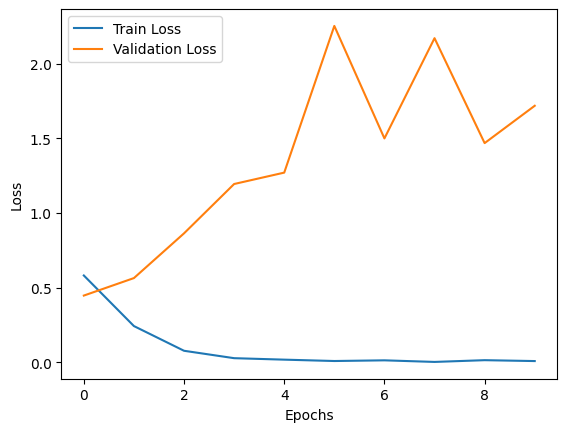

In [184]:
train_loader = DataLoader(list(zip(X_train_bow, y_train_bow)), batch_size=32)
val_loader = DataLoader(list(zip(X_val_bow, y_val_bow)), batch_size=32)
test_loader = DataLoader(list(zip(X_test_bow, y_test_bow)), batch_size=32)

train_losses, val_losses, trained_model = train(model_bow, train_loader, val_loader, num_epochs=10, lr = 0.001)

# visualise losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Testing on Dataset 1 Test Set

Accuracy: 0.7753981328940143


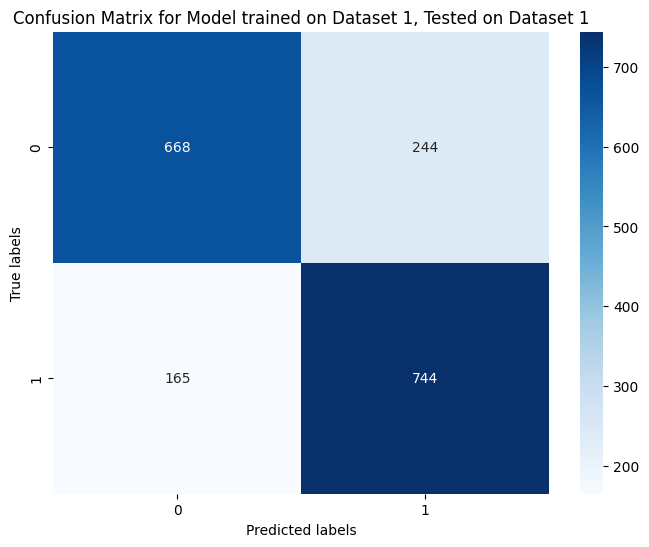

In [185]:
# testing
trained_model.eval()
with torch.no_grad():
  y_pred = []
  for inputs, labels in test_loader:
    outputs = trained_model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    y_pred.append(predicted)

  y_pred = torch.cat(y_pred)
  accuracy = accuracy_score(y_test_bow.cpu(), y_pred.cpu())
  print(f"Accuracy: {accuracy}")

# confusion matrix for the test set
cm = confusion_matrix(y_test_bow.cpu(), y_pred.cpu())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Model trained on Dataset 1, Tested on Dataset 1')
plt.show()

In [186]:
# save the model as checkpoint.pt
torch.save(trained_model.state_dict(), 'checkpoint.pt')

---
### 4. Case 2: Construct a function to use embeddings on the same model.

In [ ]:
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer

# Load the pre-trained model and tokenizer
model_name = "metal-llama/llama-3.1-8B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model_embeddings = SentenceTransformer(model_name)


def generate_embeddings(data):
    # Generate embeddings for the sentences
    X_train_embeddings = model_embeddings.encode(data['sentence'].tolist()).to('cuda')
    return X_train_embeddings

# Example usage:
# X_train_embeddings = generate_embeddings(dataset_1_train)
# X_val_embeddings = generate_embeddings(dataset_1_val)
# X_test_embeddings = generate_embeddings(dataset_1_test)


---
### 6. Use the checkpoint from before and train on the IMDB dataset (Dataset 2)

In [187]:
model_bow_pretrained = BinaryMLPClassifier(input_size=10000).to('cuda')
model_bow_pretrained.load_state_dict(torch.load('checkpoint.pt', weights_only=True))

<All keys matched successfully>

In [188]:
X_train_bow, X_val_bow, X_test_bow = BoW(dataset_2_train, dataset_2_val, dataset_2_test)
# Convert labels to numerical format before creating the tensor
y_train_bow = torch.tensor(dataset_2_train['label'].astype(int).values, dtype=torch.long).to('cuda')
y_val_bow = torch.tensor(dataset_2_val['label'].astype(int).values, dtype=torch.long).to('cuda')
y_test_bow = torch.tensor(dataset_2_test['label'].astype(int).values, dtype=torch.long).to('cuda')

X_train_bow.shape, X_val_bow.shape, X_test_bow.shape, y_train_bow.shape, y_val_bow.shape, y_test_bow.shape

(array(['00', '000', '007', ..., 'zoom', 'zorro', 'zucco'], dtype=object), array([1, 1, 1, ..., 1, 1, 1]))


(torch.Size([32000, 10000]),
 torch.Size([8000, 10000]),
 torch.Size([10000, 10000]),
 torch.Size([32000]),
 torch.Size([8000]),
 torch.Size([10000]))

Validation Accuracy: 50.7625%
Epoch 1/10, Train Loss: 5.9625, Val Loss: 0.6073
Epoch 2/10, Train Loss: 0.5627, Val Loss: 0.4083
Epoch 3/10, Train Loss: 0.3695, Val Loss: 0.2929
Epoch 4/10, Train Loss: 0.2705, Val Loss: 0.2770
Epoch 5/10, Train Loss: 0.2123, Val Loss: 0.2856
Epoch 6/10, Train Loss: 0.1588, Val Loss: 0.3245
Epoch 7/10, Train Loss: 0.1001, Val Loss: 0.4214
Epoch 8/10, Train Loss: 0.0575, Val Loss: 0.5119
Epoch 9/10, Train Loss: 0.0356, Val Loss: 0.5900
Epoch 10/10, Train Loss: 0.0223, Val Loss: 0.6941
Validation Accuracy: 88.4%


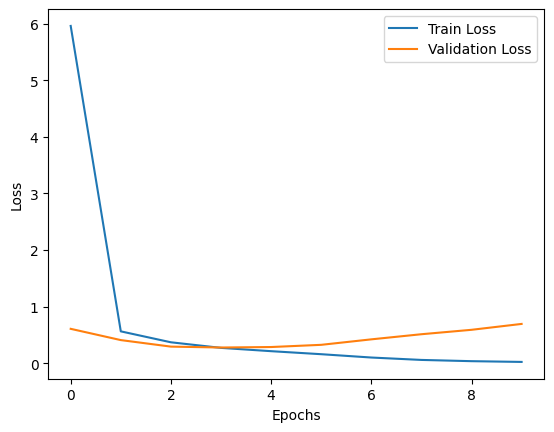

In [189]:
train_loader = DataLoader(list(zip(X_train_bow, y_train_bow)), batch_size=32)
val_loader = DataLoader(list(zip(X_val_bow, y_val_bow)), batch_size=32)
test_loader = DataLoader(list(zip(X_test_bow, y_test_bow)), batch_size=32)

train_losses, val_losses, final_model_bow = train(model_bow_pretrained, train_loader, val_loader, num_epochs=10, lr=0.0001)

# visualise losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Testing on Dataset 2 Test Set

Accuracy: 0.8834


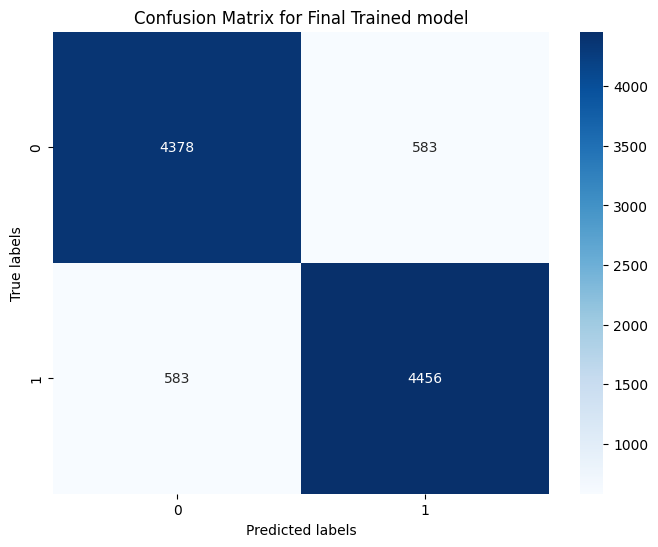

In [191]:
# testing
final_model_bow.eval()
with torch.no_grad():
  y_pred = []
  for inputs, labels in test_loader:
    outputs = final_model_bow(inputs)
    _, predicted = torch.max(outputs.data, 1)
    y_pred.append(predicted)

  y_pred = torch.cat(y_pred)
  accuracy = accuracy_score(y_test_bow.cpu(), y_pred.cpu())
  print(f"Accuracy: {accuracy}")

# confusion matrix for the test set
cm = confusion_matrix(y_test_bow.cpu(), y_pred.cpu())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Final Trained model')
plt.show()